 ## HW4 - EuroSAT Land Use and Land Cover Classification using Deep Learning
 
In this homework your task is to implement deep learning models to solve a typical problem in satellite imaging  using a benchmark dataset. The homework was designed to make you work on increasingly more complex models. We hope that the homework will be very helpful to improve your skills and knowledge in deep learning!


### S1:

- Visit the EuroSAT data description page and download the data: https://github.com/phelber/eurosat

- Split the data into training (50%) and testing sets (50%), stratified on class labels (equal percentage of each class type in train and test sets).

- Convert each RGB image to grayscale and flatten the images into a data matrix (n x p: n = #samples, p = #pixels in each image)


In [1]:
#!pip install tensorflow_datasets
# !pip install rasterio

In [14]:
## data processing and reading
import os
import numpy as np 
import pandas as pd 
import math
import random, tqdm
import PIL
import PIL.Image
import rasterio
import cv2
import zipfile

## plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## modeling
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import math
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten, BatchNormalization
from keras.applications import mobilenet
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [3]:
## Run from Colab
# from google.colab import drive

# drive.mount('/content/drive')

# path = "/content/drive/MyDrive/Grad School/Penn_MUSA/Spring2022/650_RemoteSensing/Homework/HW4/Data/EuroSAT_RGB/"
# model_path = "/content/drive/MyDrive/Grad School/Penn_MUSA/Spring2022/650_RemoteSensing/Homework/HW4/models"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Local run
path = "./Data/EuroSAT_RGB/"
model_path = './models/'

In [3]:
imgs = []
labels = os.listdir(path)

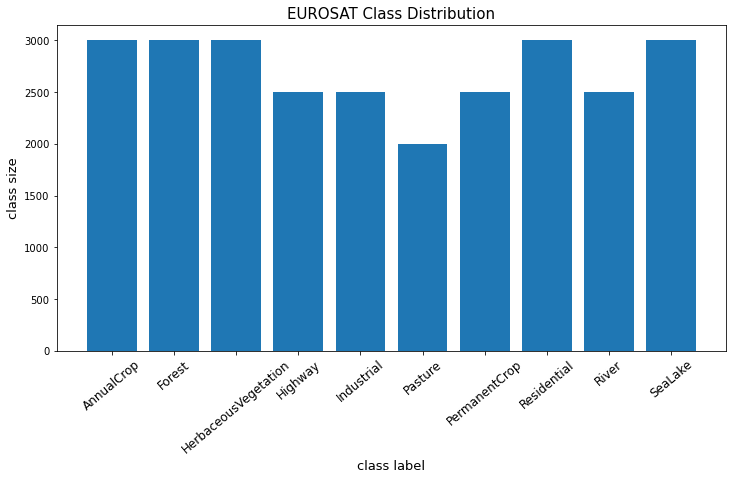

In [5]:
# plot class distributions of whole dataset
counts = {}

for l in labels:
    counts[l] = len(os.listdir(os.path.join(path, l)))

    
plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

In [6]:
## Get all of the class names from their directory names
classNames = os.listdir(path)

## Find the total number of classes
numClass = len(classNames)

## Identify the number of images in each class by reading the number of files
## in each class directory
lenClass = np.zeros(numClass)
for i in np.arange(0, numClass):
  lenClass[i] = len(os.listdir(path + '/' + classNames[i]))
print(classNames)
print(lenClass)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
[3000. 3000. 3000. 2500. 2500. 2000. 2500. 3000. 2500. 3000.]


(64, 64, 3)

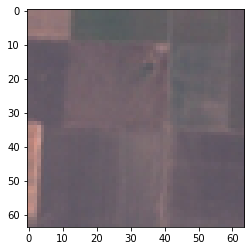

In [7]:
## Find the shape of one image so we can load the rest
imgSel = path + '/' + classNames[0] + '/' + os.listdir(path + '/' + classNames[0])[0]
img = PIL.Image.open(imgSel, 'r')
plt.imshow(np.asarray(img))
np.asarray(img).shape

In [8]:
## numImg is the total number of images in the dataset
numImg  = int(lenClass.sum())

## numPixels is the number of pixels in each image
numPixels = np.asarray(img).shape # 64 x 64 x 3 px in rgb img
numGrayPixels = np.prod(np.asarray(img.convert('L')).shape) # 4096 px in grayscale

In [10]:
## Initialize arrays for Grayscale imgs
X = np.zeros([numImg, numGrayPixels], dtype='uint8')
y = np.zeros(numImg, dtype='uint8')

# labels = []

In [11]:
## Read images vectors into X array
## Read image labels into y array

imgInd=0
for i in np.arange(0, numClass):
  className = classNames[i]
  for imgName in os.listdir(path + '/' + className):
    img = PIL.Image.open(path + '/' + className + '/' + imgName, 'r').convert('L') # convert imgs to grayscale
    imgVec = np.asarray(img).flatten() #flatten img to np array, rather than img matrix

    # Append to grayscale dataset
    X[imgInd,:] = imgVec
    y[imgInd] = i
    # labels.append(className)

    imgInd += 1

# print(X.shape)
# print(y.shape)

In [ ]:
# label_names, yLabels = np.unique(labels, return_inverse=True)
# label_Dict = dict(zip(np.unique(y).astype(int), label_names))
# print(label_Dict)
# np.array(np.unique(y, return_counts=True)).T

In [ ]:
scalar = MinMaxScaler()
scalar.fit(X.reshape(X.shape[0], -1))
X = scalar.transform(X.reshape(X.shape[0], -1).reshape(X.shape))

In [13]:
## Create Train/Test split 50:50 split
from sklearn.model_selection import train_test_split
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5, stratify = y, random_state=42)

In [14]:
# class distribution for y1
np.array(np.unique(y1, return_counts=True)).T

array([[   0, 1500],
       [   1, 1500],
       [   2, 1500],
       [   3, 1250],
       [   4, 1250],
       [   5, 1000],
       [   6, 1250],
       [   7, 1500],
       [   8, 1250],
       [   9, 1500]], dtype=int64)

In [15]:
# class distribution for y2
np.array(np.unique(y2, return_counts=True)).T

array([[   0, 1500],
       [   1, 1500],
       [   2, 1500],
       [   3, 1250],
       [   4, 1250],
       [   5, 1000],
       [   6, 1250],
       [   7, 1500],
       [   8, 1250],
       [   9, 1500]], dtype=int64)

In [21]:
#Convert class vectors to binary class matrices
y1 = to_categorical(y1, numClass, dtype='uint8')
y2 = to_categorical(y2, numClass, dtype='uint8')

### S2:

- Implement a first deep learning model (M.1) using a fully connected network with a single fully connected layer (i.e: input layer + fully connected layer as the output layer). 

Q2.1: Calculate classification accuracy on the test data.
- **Classification Accuracy on test data:** *24.6%*  

In [9]:
## Declare modeling parameters
NUM_EPOCH = 100
B_SIZE = 64

In [23]:
# save model here
model_file = '{}/m1.h5'.format(model_path)

checkpoint = ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [checkpoint]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                40970     
Total params: 40,970
Trainable params: 40,970
Non-trainable params: 0
_________________________________________________________________


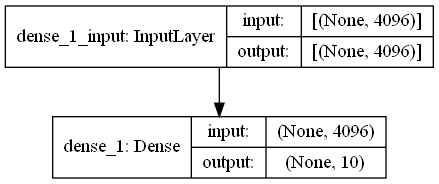

In [24]:
m1 = Sequential()
m1.add(Dense(10, input_shape=(4096,), activation='softmax'))

m1.summary() 
plot_model(m1, show_shapes=True, show_layer_names=True)

In [25]:
## Compile the model
m1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
## Train the model
md1_hist = m1.fit(X1, y1, 
                  batch_size=B_SIZE, 
                  epochs=NUM_EPOCH, 
                  callbacks = callback_list, 
                  verbose=1, 
                  validation_data=(X2, y2))

Epoch 1/100
211/211 [==============================] - 9s 41ms/step - loss: 2.2510 - accuracy: 0.1515 - val_loss: 2.1512 - val_accuracy: 0.1987
Epoch 2/100
211/211 [==============================] - 7s 33ms/step - loss: 2.1552 - accuracy: 0.2044 - val_loss: 2.1590 - val_accuracy: 0.2116ETA: 0s - loss: 2.1561 - accuracy: 0.
Epoch 3/100
211/211 [==============================] - 5s 26ms/step - loss: 2.1090 - accuracy: 0.2444 - val_loss: 2.1129 - val_accuracy: 0.2052
Epoch 4/100
211/211 [==============================] - 6s 29ms/step - loss: 2.0738 - accuracy: 0.2664 - val_loss: 2.1443 - val_accuracy: 0.2112
Epoch 5/100
211/211 [==============================] - 7s 31ms/step - loss: 2.0455 - accuracy: 0.2686 - val_loss: 2.1633 - val_accuracy: 0.2246
Epoch 6/100
211/211 [==============================] - 6s 27ms/step - loss: 2.0284 - accuracy: 0.2810 - val_loss: 2.0876 - val_accuracy: 0.2150
Epoch 7/100
211/211 [==============================] - 5s 24ms/step - loss: 1.9841 - accuracy: 0.28

In [27]:
score = m1.evaluate(X2, y2, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.0569610595703125
Test accuracy: 0.2459259331226349


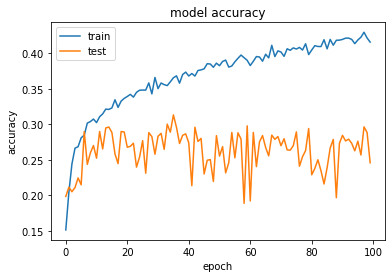

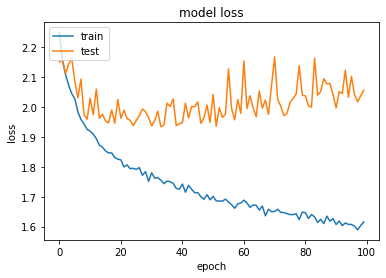

In [28]:
plt.plot(md1_hist.history['accuracy'])
plt.plot(md1_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(md1_hist.history['loss'])
plt.plot(md1_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [49]:
# y_test_true_tmp = np.argmax(y2, axis = 1)
# label_count = np.unique(y_test_true_tmp, return_counts = True)[1]

In [54]:
# Define functions for evaluating model accuracy by class and overall

# def eval_model_by_class(model, test_set):

#   y_test_pred_tmp = (model.predict(test_set) > 0.5).astype("int32")

#   y_test_true = [label_Dict[x] for x in y_test_true_tmp]
#   y_test_pred = [label_Dict[x] for x in y_test_pred_tmp]

#   pred_df = pd.DataFrame({'y_true': y_test_true, 'y_pred': y_test_pred})
#   pred_df['accurate_preds'] = pred_df.y_true == pred_df.y_pred
#   pred_df = pred_df.groupby(['y_true']).sum().reset_index()
#   pred_df['label_count'] = label_count
#   pred_df['class_acc'] = pred_df.accurate_preds / pred_df.label_count
#   pred_df = pred_df.sort_values(by = 'class_acc').reset_index()
#   pred_df['overall_acc'] = sum(pred_df.accurate_preds) / sum(pred_df.label_count)
#   pred_df = pred_df.sort_values('y_true').reset_index(drop = True)

#   return(pred_df)

# def find_wrong_preds(model, test_set):
#   y_test_pred_tmp = (model.predict(test_set) > 0.5).astype("int32")

#   y_test_true = [label_Dict[x] for x in y_test_true_tmp]
#   y_test_pred = [label_Dict[x] for x in y_test_pred_tmp]

#   pred_df = pd.DataFrame({'y_true': y_test_true, 'y_pred': y_test_pred})
#   pred_df['accurate_preds'] = pred_df.y_true == pred_df.y_pred
#   # pred_df = pred_df.sort_values('y_true').reset_index(drop = True)
#   pred_df = pred_df.sort_values('y_true')

#   return(pred_df)

In [ ]:
# m1_pred_df = eval_model_by_class(m1, X2)
# m1_pred_df


### S3:

- Implement a second deep learning model (M.2) adding an additional fully connected hidden layer (with an arbitrary number of nodes) to the previous model. 

Q3.1: Calculate classification accuracy on the test data.  
- **Classification Accuracy on test data:** *39.8%* 

In [32]:
# save model here
model_file = '{}/m2.h5'.format(model_path)

checkpoint = ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [checkpoint]

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               1048832   
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 1,051,402
Trainable params: 1,051,402
Non-trainable params: 0
_________________________________________________________________


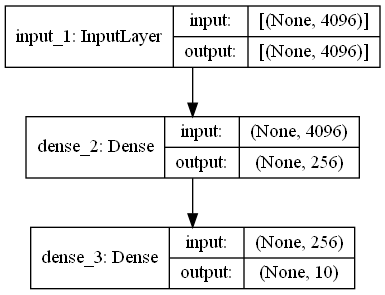

In [33]:
m2 = Sequential()
m2.add(Input(shape = (4096,)))
m2.add(Dense(256, activation='relu'))
m2.add(Dense(10, activation='softmax'))

m2.summary() 
plot_model(m2, show_shapes=True, show_layer_names=True)

In [34]:
## Compile the model
m2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model
md2_hist = m2.fit(X1, y1, 
                  batch_size=B_SIZE, 
                  epochs=NUM_EPOCH, 
                  callbacks = callback_list, 
                  verbose=1, 
                  validation_data=(X2, y2))

Epoch 1/100
211/211 [==============================] - 2s 10ms/step - loss: 2.2905 - accuracy: 0.1490 - val_loss: 2.1513 - val_accuracy: 0.1664
Epoch 2/100
211/211 [==============================] - 2s 9ms/step - loss: 2.1370 - accuracy: 0.1910 - val_loss: 2.0969 - val_accuracy: 0.2409
Epoch 3/100
211/211 [==============================] - 2s 8ms/step - loss: 2.0532 - accuracy: 0.2599 - val_loss: 2.0532 - val_accuracy: 0.2290
Epoch 4/100
211/211 [==============================] - 2s 9ms/step - loss: 1.9622 - accuracy: 0.2910 - val_loss: 1.9237 - val_accuracy: 0.2827
Epoch 5/100
211/211 [==============================] - 2s 9ms/step - loss: 1.8756 - accuracy: 0.3123 - val_loss: 1.8817 - val_accuracy: 0.3135
Epoch 6/100
211/211 [==============================] - 3s 12ms/step - loss: 1.8177 - accuracy: 0.3136 - val_loss: 1.8217 - val_accuracy: 0.2984
Epoch 7/100
211/211 [==============================] - 2s 10ms/step - loss: 1.7811 - accuracy: 0.3241 - val_loss: 1.8600 - val_accuracy: 0.2

In [35]:
score = m2.evaluate(X2, y2, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.7650378942489624
Test accuracy: 0.3977777659893036


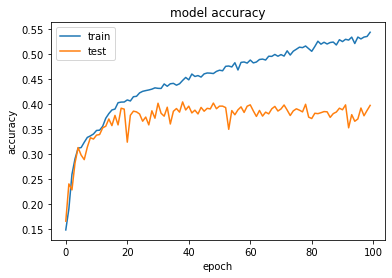

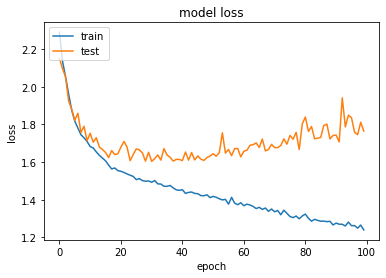

In [36]:
plt.plot(md2_hist.history['accuracy'])
plt.plot(md2_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(md2_hist.history['loss'])
plt.plot(md2_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# m2_pred_df = eval_model_by_class(m2, X1)
# m2_pred_df

### S4:

- Implement a third deep learning model (M.3) adding two additional fully connected hidden layers (with arbitrary number of nodes) for a total of four, as well as drop-out layers to the previous model. 

Q4.1: Calculate classification accuracy on the test data.
- **Classification Accuracy on test data:** *31.9%* 

Q4.2: Compare against previous models. Which model was the "best"? Why?
- Of the first three models tested, `m2` is the *best* based on the testing accuracy. 
- Additionally, when comparing temporal trends in testing loss and accuracy, `m1` and `m3` exhibit larger fluctuations in both loss and accuracy compared to `m2`
- However, the lower performance of `m3` may be explained by the inclusion of the *dropout* layers, which are included to prevent over-fitting by setting random sets of input units to 0.

In [37]:
# save model here
model_file = '{}/m3.h5'.format(model_path)

checkpoint = ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [checkpoint]

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               1048832   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)               

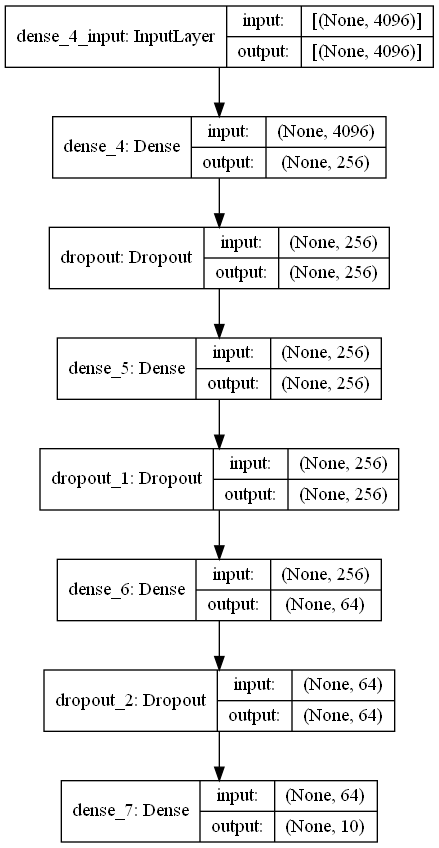

In [38]:
m3 = Sequential()
m3.add(Dense(256, input_shape=(4096,), activation='relu'))
m3.add(Dropout(0.2))
m3.add(Dense(256, activation='relu'))
m3.add(Dropout(0.2))
m3.add(Dense(64, activation='relu'))
m3.add(Dropout(0.2))
m3.add(Dense(10, activation='softmax'))

m3.summary() 
plot_model(m3, show_shapes=True, show_layer_names=True)

In [39]:
## Compile the model
m3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model
md3_hist = m3.fit(X1, y1, 
                  batch_size=B_SIZE, 
                  epochs=NUM_EPOCH, 
                  callbacks = callback_list,
                  verbose=1, 
                  validation_data=(X2, y2))

Epoch 1/100
211/211 [==============================] - 3s 12ms/step - loss: 2.2148 - accuracy: 0.1719 - val_loss: 2.0178 - val_accuracy: 0.3037
Epoch 2/100
211/211 [==============================] - 2s 10ms/step - loss: 1.9622 - accuracy: 0.2587 - val_loss: 1.8186 - val_accuracy: 0.3108
Epoch 3/100
211/211 [==============================] - 2s 9ms/step - loss: 1.8535 - accuracy: 0.3032 - val_loss: 1.7892 - val_accuracy: 0.3221
Epoch 4/100
211/211 [==============================] - 2s 9ms/step - loss: 1.8054 - accuracy: 0.3216 - val_loss: 1.7543 - val_accuracy: 0.3176
Epoch 5/100
211/211 [==============================] - 2s 9ms/step - loss: 1.7907 - accuracy: 0.3288 - val_loss: 1.7698 - val_accuracy: 0.3155
Epoch 6/100
211/211 [==============================] - 2s 9ms/step - loss: 1.7699 - accuracy: 0.3352 - val_loss: 1.7417 - val_accuracy: 0.3345
Epoch 7/100
211/211 [==============================] - 2s 9ms/step - loss: 1.7592 - accuracy: 0.3390 - val_loss: 1.7600 - val_accuracy: 0.32

In [40]:
score = m3.evaluate(X2, y2, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.9385225772857666
Test accuracy: 0.31977778673171997


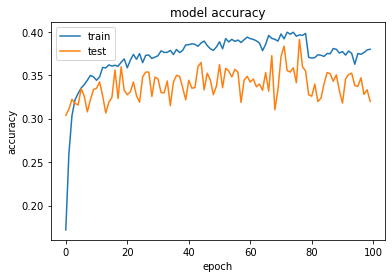

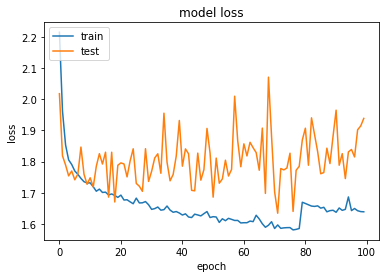

In [41]:
plt.plot(md3_hist.history['accuracy'])
plt.plot(md3_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(md3_hist.history['loss'])
plt.plot(md3_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# m3_pred_df = eval_model_by_class(m3, X1)
# m3_pred_df

### S5:

- Take the original RGB images and do not vectorize them. Use these images as the data input for the following models (M.4 and M.5).
- Implement a fourth CNN model (M.4) that includes the following layers: Conv2D, MaxPooling2D, Dropout, Flatten, Dense. 

Q5.1: Calculate classification accuracy on the test data.
- **Classification Accuracy on test data:** *76.1%* 

Q5.2: Compare against previous models. Which model was the "best"? Why?
- It is clear that `m4` is the *best* model thus far based on it's testing accuracy. 
- This is likely due to the fact that we included convolutions in this model, which allow for the detection of features in an image

In [42]:
# Clear memory to make space for next steps
del X, y, X1, X2, y1, y2, m1, m2, m3, md1_hist, md2_hist, md3_hist

In [10]:
## Initialize arrays for RGB dataset
X_RGB = np.zeros([numImg, 64, 64, 3], dtype='uint8')
y = np.zeros(numImg, dtype='uint8')

## Read images vectors into X array
## Read image labels into y array

imgInd=0
for i in np.arange(0, numClass):
  className = classNames[i]
  for imgName in os.listdir(path + '/' + className):
    img = PIL.Image.open(path + '/' + className + '/' + imgName, 'r')

    # Append to RGB dataset
    X_RGB[imgInd,:] = img
    y[imgInd] = i

    imgInd += 1

# print(X_RGB.shape)
# print(y.shape)

In [11]:
scalar = MinMaxScaler()
scalar.fit(X_RGB.reshape(X_RGB.shape[0], -1))
X_RGB = scalar.transform(X_RGB.reshape(X_RGB.shape[0], -1)).reshape(X_RGB.shape)

In [12]:
# Convert class vectors to binary class matrices
y = to_categorical(y, numClass)

## Create Train/Test split 50:50 split
from sklearn.model_selection import train_test_split
X_RGB_1, X_RGB_2, y1, y2 = train_test_split(X_RGB, y, test_size=0.5, stratify = y, random_state=42)

print(X_RGB_1.shape)
print(X_RGB_2.shape)

(13500, 64, 64, 3)
(13500, 64, 64, 3)


In [12]:
# save model here
model_file = '{}/m4.h5'.format(model_path)

checkpoint = ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [checkpoint]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               14745856  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

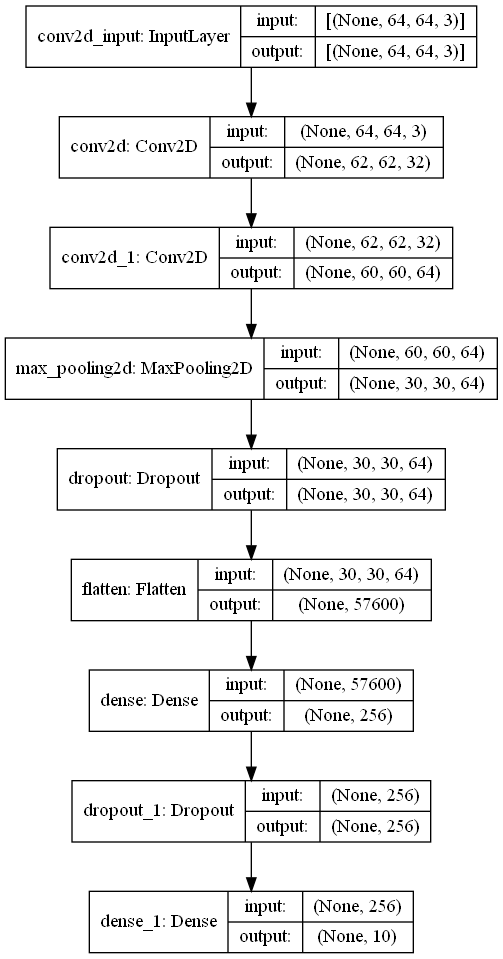

In [13]:
# Create DL model for RGB matrices
m4 = Sequential()
m4.add(Conv2D(32, kernel_size=(3, 3),  input_shape=(64,64,3), activation='relu'))
m4.add(Conv2D(64, (3, 3), activation='relu'))
m4.add(MaxPooling2D(pool_size=(2, 2))) 
m4.add(Dropout(0.2))
m4.add(Flatten())
m4.add(Dense(256, activation='relu'))
m4.add(Dropout(0.2))
m4.add(Dense(10, activation='softmax'))

m4.summary()    
plot_model(m4, show_shapes=True, show_layer_names=True)

In [16]:
## Compile the model
m4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model
md4_hist = m4.fit(X_RGB_1, y1, 
                  batch_size=B_SIZE, 
                  epochs=NUM_EPOCH, 
                  callbacks = callback_list, 
                  verbose=1, 
                  validation_data=(X_RGB_2, y2))

Epoch 1/100
211/211 [==============================] - 62s 290ms/step - loss: 1.2817 - accuracy: 0.5301 - val_loss: 0.8320 - val_accuracy: 0.7098
Epoch 2/100
211/211 [==============================] - 57s 271ms/step - loss: 0.7534 - accuracy: 0.7332 - val_loss: 0.7033 - val_accuracy: 0.7465
Epoch 3/100
211/211 [==============================] - 56s 268ms/step - loss: 0.5646 - accuracy: 0.8054 - val_loss: 0.6380 - val_accuracy: 0.7744
Epoch 4/100
211/211 [==============================] - 57s 270ms/step - loss: 0.4226 - accuracy: 0.8537 - val_loss: 0.5845 - val_accuracy: 0.80700.4211 - 
Epoch 5/100
211/211 [==============================] - 57s 270ms/step - loss: 0.3056 - accuracy: 0.8967 - val_loss: 0.5926 - val_accuracy: 0.8099
Epoch 6/100
211/211 [==============================] - 57s 270ms/step - loss: 0.2288 - accuracy: 0.9264 - val_loss: 0.6007 - val_accuracy: 0.8021
Epoch 7/100
211/211 [==============================] - 57s 269ms/step - loss: 0.1672 - accuracy: 0.9456 - val_loss:

In [17]:
score = m4.evaluate(X_RGB_2, y2, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.498631477355957
Test accuracy: 0.7641481757164001


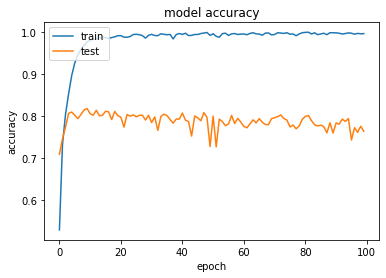

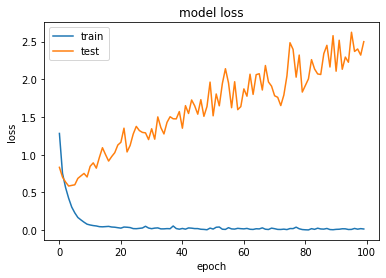

In [18]:
plt.plot(md4_hist.history['accuracy'])
plt.plot(md4_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(md4_hist.history['loss'])
plt.plot(md4_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# m4_pred_df = eval_model_by_class(m4, X1)
# m4_pred_df

### S6:

- Using RGB images from S5, implement a fifth deep learning model (M.5) targeting accuracy that will outperform all previous models. You are free to use any tools and techniques, as well as pre-trained models for transfer learning. 

Q6.1: Describe the model you built, and why you chose it.
- I used the pre-trained **MobileNet** from Keras with a flatten, dropout, and two dense layers 
- **[MobileNet](https://arxiv.org/abs/1704.04861)** is one of a series of architectures proposed by Howard et. al. in 2017
- I chose **MobileNet** for this purpose because it is light-weight and finds a balance between computation resource use and accuracy.
- I originally tested *VGG16*, but this turned out to be too computationally burdensome for Colab & my machine

Q6.2: Calculate classification accuracy on the test data.
- **Classification Accuracy on test data:** *83.3%* 

Q6.3: Compare against previous models. Which model was the "best"? Why?
- It is clear that `m6` is the *best* model thus far based on it's testing accuracy. 
- The addition of additional convolutional layers in **MobileNet** allows for higher testing accuracy. 

Q6.4: What are the two classes with the highest labeling error? Explain using data and showing mis-classified examples.
- It appears that Highway and River were the most confused classes - they were confused for eachother a total of 123 times (out of 5000 combined instances)

In [13]:
# save model here
model_file = '{}/m5.h5'.format(model_path)

checkpoint = ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [checkpoint]

In [15]:
conv_base = mobilenet.MobileNet(include_top=False, input_shape = (64, 64, 3))
conv_base.summary()

17235968/17225924 [==============================] - 6s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128       
_________________________________________________

In [16]:
# how many weights are trainable in the VGG16 model?
len(conv_base.trainable_weights)

81

In [17]:
# freeze the weights
for layer in conv_base.layers:
  layer.trainable = False

In [18]:
# now there are 0
len(conv_base.trainable_weights)

0

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 2, 2, 1024)        3228864   
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2097664   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 5,331,658
Trainable params: 2,102,794
Non-trainable params: 3,228,864
_________________________________________________________________


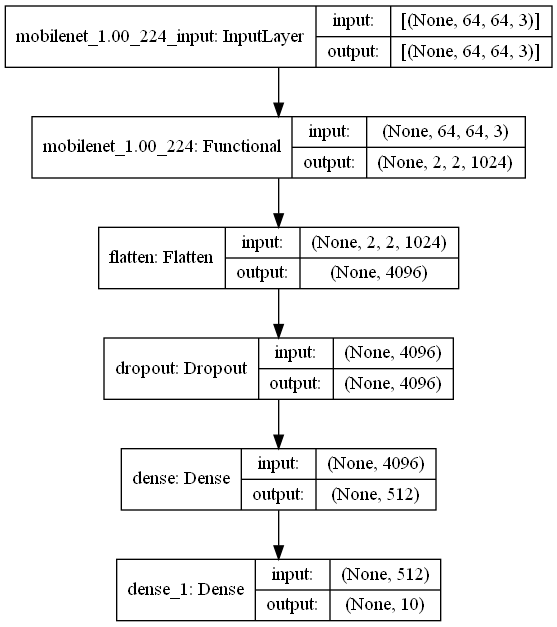

In [19]:
m5 = Sequential()

m5.add(conv_base)

m5.add(Flatten())
m5.add(Dropout(0.5))
m5.add(Dense(512, activation='relu'))
m5.add(Dense(10, activation='softmax'))

m5.summary() 
plot_model(m5, show_shapes=True, show_layer_names=True)

In [20]:
## Compile the model
m5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model
md5_hist = m5.fit(X_RGB_1, y1, 
                  batch_size=B_SIZE, 
                  epochs=NUM_EPOCH, 
                  callbacks = callback_list,
                  verbose=1, 
                  validation_data=(X_RGB_2, y2))

Epoch 1/100
211/211 [==============================] - 30s 132ms/step - loss: 0.8451 - accuracy: 0.7361 - val_loss: 0.5428 - val_accuracy: 0.8239
Epoch 2/100
211/211 [==============================] - 28s 133ms/step - loss: 0.5273 - accuracy: 0.8226 - val_loss: 0.5262 - val_accuracy: 0.8279
Epoch 3/100
211/211 [==============================] - 26s 122ms/step - loss: 0.4368 - accuracy: 0.8501 - val_loss: 0.5154 - val_accuracy: 0.8279- loss: 0
Epoch 4/100
211/211 [==============================] - 25s 120ms/step - loss: 0.3794 - accuracy: 0.8701 - val_loss: 0.5194 - val_accuracy: 0.8277ss: 0.3788 - accuracy: 
Epoch 5/100
211/211 [==============================] - 26s 124ms/step - loss: 0.3249 - accuracy: 0.8881 - val_loss: 0.5003 - val_accuracy: 0.8379
Epoch 6/100
211/211 [==============================] - 27s 128ms/step - loss: 0.2887 - accuracy: 0.8996 - val_loss: 0.5050 - val_accuracy: 0.8355
Epoch 7/100
211/211 [==============================] - 25s 120ms/step - loss: 0.2609 - accur

In [21]:
score = m5.evaluate(X_RGB_2, y2, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.166666865348816
Test accuracy: 0.8337777853012085


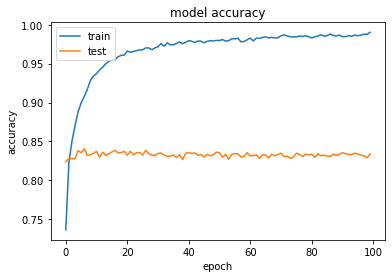

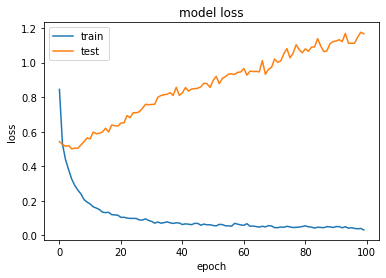

In [22]:
plt.plot(md5_hist.history['accuracy'])
plt.plot(md5_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(md5_hist.history['loss'])
plt.plot(md5_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# m5_pred_df = eval_model_by_class(m5, X1)
# m5_pred_df

In [35]:
y_pred = m5.predict(X_RGB_2)
y_pred = np.argmax(y_pred, axis=1)
y2 = np.argmax(y2, axis=1)
y_pred = y_pred.astype('int32')
y2 = y2.astype('int32')

print(y2.shape)
print(y_pred.shape)

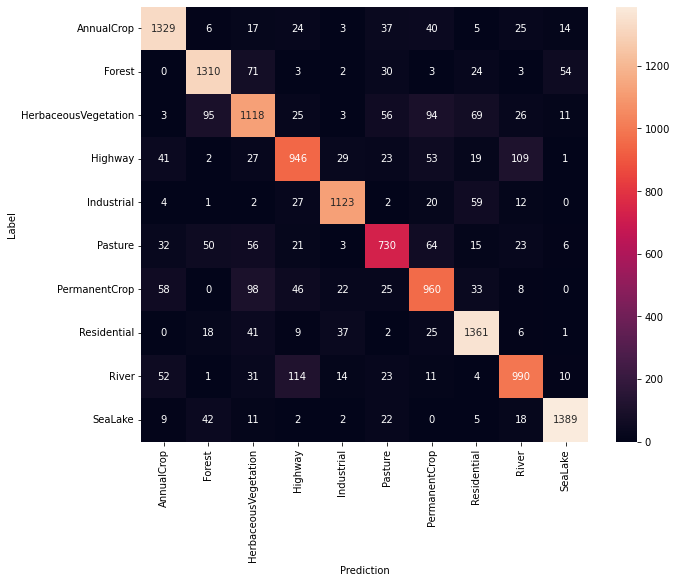

In [37]:
# See https://www.tensorflow.org/tutorials/audio/simple_audio for how to set up confusion mtx
confusion_mtx = tf.math.confusion_matrix(y2, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=classNames,
            yticklabels=classNames,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


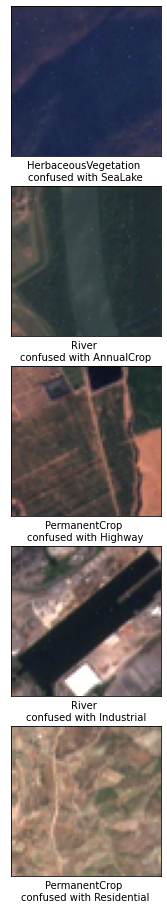

In [54]:
misclass = np.array(np.where(y2 != y_pred))[0]

plt.figure(figsize=(16,16))

for i in range(5):
    plt.subplot(5,1,i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid(False)
    plt.imshow(X_RGB_2[misclass[i]])
    plt.xlabel("{} \nconfused with {}".format(str(classNames[y2[misclass[i]]]), str(classNames[y_pred[misclass[i]]]) ))
plt.tight_layout    
plt.show()

### S7:

- Apply your best model on multispectral images. You may use whichever image channels you wish, so long as you use more than just RGB (although you are not required to use any color channels).

Q7.1: Calculate classification accuracy on the test data.

Q7.2: Compare against results using RGB images.

In [ ]:
# Clear memory to make space for next steps
# del X_RGB, y, X_RGB_1, X_RGB_2, y1, y2, m4, m5, md4_hist, md5_hist

In [46]:
def normalizeBand(band):
  band_norm = np.interp(band, (band.min(), band.max()), (0, 1))
  return band_norm

In [47]:
# Local run
path = "./Data/EuroSAT_AllBands/"

## Get all of the class names from their directory names
classNames = os.listdir(path)

## Find the total number of classes
numClass = len(classNames)

## Identify the number of images in each class by reading the number of files
## in each class directory
lenClass = np.zeros(numClass)
for i in np.arange(0, numClass):
  lenClass[i] = len(os.listdir(path + '/' + classNames[i]))
print(classNames)
print(lenClass)

## numImg is the total number of images in the dataset
numImg  = int(lenClass.sum())

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
[3000. 3000. 3000. 2500. 2500. 2000. 2500. 3000. 2500. 3000.]


In [48]:
img_MS = np.zeros([numImg, 64, 64, 13], dtype="float32")
labels = np.empty(numImg, dtype = 'S20')

In [49]:
## Read images vectors into X array
## Read image labels into y array

imgInd=0
for i in np.arange(0, numClass):
  className = classNames[i]
  for imgName in os.listdir(path + '/' + className):
    with rasterio.open(path + '/' + className + '/' + imgName, 'r') as img:
      tmp = np.moveaxis(img.read(), 0, 2)
      img_MS[imgInd,:] = normalizeBand(tmp)
      labels[imgInd] = i
      imgInd += 1


In [61]:
label_names, y_labels = np.unique(labels, return_inverse=True)

label_Dict = dict(zip(np.unique(y_labels), label_names))
num_classes = len(np.array(np.unique(y_labels)))

10

In [89]:
# Select bands 8, 4, and 3 - for color infrared 
X_MS = img_MS[:,:,:,np.r_[2:4, 7]]
X_MS.shape


(27000, 64, 64, 3)

In [90]:
scalar = MinMaxScaler()
scalar.fit(X_MS.reshape(X_MS.shape[0], -1))
X_MS = scalar.transform(X_MS.reshape(X_MS.shape[0], -1)).reshape(X_MS.shape)


In [91]:
shuffled = shuffle(y_labels, random_state = 11)

x_shuffled = X_MS[shuffled]
y_shuffled = y_labels[shuffled]

In [92]:
#X_train3, X_test3, y_train3, y_test3 = train_test_split(x_shuffled, y_shuffled, stratify = yBal, train_size = 0.5, random_state=42)
X_trainMS, X_testMS, y_trainMS, y_testMS = train_test_split(X_MS, y_labels, stratify = y_labels, train_size = 0.5, random_state=11)

In [93]:
dshape = X_trainMS.shape[1:]

# convert class vectors to binary class matrices
y_trainMSB = to_categorical(y_trainMS, num_classes)
y_testMSB = to_categorical(y_testMS, num_classes)

y_trainMSB.shape

(13500, 10)

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 32, 32, 32) 

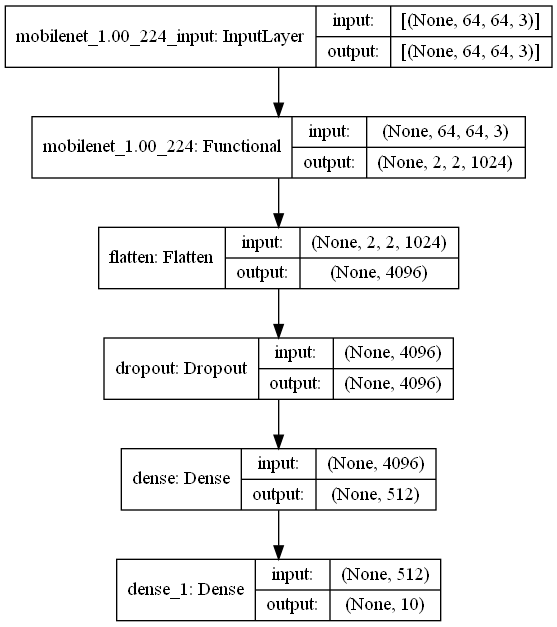

In [94]:
conv_base = mobilenet.MobileNet(include_top=False, input_shape = (64, 64, 3))
conv_base.summary()

# len(conv_base.trainable_weights)

# freeze the weights
for layer in conv_base.layers:
  layer.trainable = False

# now there are 0
# len(conv_base.trainable_weights)


m6 = Sequential()

m6.add(conv_base)
m6.add(Flatten())
m6.add(Dropout(0.5))
m6.add(Dense(512, activation='relu'))
m6.add(Dense(10, activation='softmax'))

m5.summary() 
plot_model(m5, show_shapes=True, show_layer_names=True)

In [98]:
# save model here
model_file = '{}/m6.h5'.format(model_path)

checkpoint = ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

early_stop = EarlyStopping(monitor = 'val_loss', # what is the metric to measure
                              patience = 15, # how many epochs to continue running the model after seeing an increase in val_loss
                              restore_best_weights = True) # update the model with the best-seen weights?

reduce_LR = ReduceLROnPlateau(monitor = 'val_loss',
                                              factor = 0.1,
                                              patience = 5) # to make sure early_stop is what stops the model

callback_list = [reduce_LR, early_stop, checkpoint]

In [99]:
## Compile the model
m6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model
md6_hist = m6.fit(X_trainMS, 
                  y_trainMSB, 
                  batch_size=B_SIZE, 
                  epochs=NUM_EPOCH,
                  callbacks= callback_list,
                  verbose=1, 
                  validation_data=(X_testMS, y_testMSB))

Epoch 1/100
211/211 [==============================] - 29s 123ms/step - loss: 0.2001 - accuracy: 0.9297 - val_loss: 0.6345 - val_accuracy: 0.8304
Epoch 2/100
211/211 [==============================] - 25s 117ms/step - loss: 0.1764 - accuracy: 0.9399 - val_loss: 0.6537 - val_accuracy: 0.82650.1762 - ac
Epoch 3/100
211/211 [==============================] - 24s 114ms/step - loss: 0.1540 - accuracy: 0.9457 - val_loss: 0.6951 - val_accuracy: 0.8244
Epoch 4/100
211/211 [==============================] - 25s 117ms/step - loss: 0.1674 - accuracy: 0.9446 - val_loss: 0.6788 - val_accuracy: 0.8271A: 2s - loss: 0.1670 - accuracy: 0.94 - ETA: 2s - loss: 0.1670 - accuracy - ETA: 1s - loss: 0.1670 -  - ETA: 1s - loss: 0 - ETA: 0s - loss: 0
Epoch 5/100
211/211 [==============================] - 26s 122ms/step - loss: 0.1436 - accuracy: 0.9507 - val_loss: 0.6490 - val_accuracy: 0.8296
Epoch 6/100
211/211 [==============================] - 25s 120ms/step - loss: 0.1372 - accuracy: 0.9567 - val_loss: 0.

In [ ]:
score = m6.evaluate(X_testMS, y_testMSB, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
plt.plot(md6_hist.history['accuracy'])
plt.plot(md6_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(md6_hist.history['loss'])
plt.plot(md6_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = m6.predict(y_testMSB)
y_pred = np.argmax(y_pred, axis=1)
y_pred = y_pred.astype('int32')

y_testMSB = np.argmax(y_testMSB, axis=1)
y_testMSB = y_testMSB.astype('int32')

print(y_testMSB.shape)
print(y_pred.shape)

In [ ]:
# See https://www.tensorflow.org/tutorials/audio/simple_audio for how to set up confusion mtx
confusion_mtx = tf.math.confusion_matrix(y_testMSB, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=classNames,
            yticklabels=classNames,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
misclass = np.array(np.where(y_testMSB != y_pred))[0]

plt.figure(figsize=(16,16))

for i in range(5):
    plt.subplot(5,1,i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid(False)
    plt.imshow(X_testMS[misclass[i]])
    plt.xlabel("{} \nconfused with {}".format(str(classNames[y_testMSB[misclass[i]]]), str(classNames[y_pred[misclass[i]]]) ))
plt.tight_layout    
plt.show()

In [ ]:
# !pip install tifffile

In [ ]:
# # from osgeo import gdal, ogr
# import tifffile

# # Identify images in the directory:
# imgs = []
# path = "/content/drive/MyDrive/Grad School/Penn_MUSA/Spring2022/650_RemoteSensing/Homework/HW4/Data/EuroSAT_AllBands/"
# labels = os.listdir(path)

# ## Get all of the class names from their directory names
# classNames = os.listdir(path)

# ## Find the total number of classes
# numClass = len(classNames)

# ## Identify the number of images in each class by reading the number of files
# ## in each class directory
# lenClass = np.zeros(numClass)
# for i in np.arange(0, numClass):
#   lenClass[i] = len(os.listdir(path + '/' + classNames[i]))

# ## Find the shape of one image so we can load the rest
# imgSel = path + '/' + classNames[0] + '/' + os.listdir(path + '/' + classNames[0])[0]
# img = tifffile.imread(imgSel)

# ## numImg is the total number of images in the dataset
# numImg  = int(lenClass.sum())

# ## numPixels is the number of pixels in each image
# numPixels = np.asarray(img).shape # 64 x 64 x 3 px in rgb img

# ## Initialize arrays for RGB dataset
# X_MS = np.zeros([numImg, 64, 64, 13])
# y_MS = np.zeros(numImg)

In [ ]:
# ## Read images vectors into X array
# ## Read image labels into y array

# imgInd=0
# for i in np.arange(0, numClass):
#   className = classNames[i]
#   for imgName in os.listdir(path + '/' + className):
#     img = tifffile.imread(path + '/' + className + '/' + imgName, 'r')

#     X_MS[imgInd,:] = img
#     y_MS[imgInd] = i

#     imgInd = imgInd + 1

# print(X_MS.shape)
# print(y_MS.shape)